In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import time
import sys
import os
from typing import Dict, Tuple
sys.path.append(os.path.abspath(".."))
from src.qst.models.bayes import BayesQST

from typing import Optional
from scipy.linalg import sqrtm

def fidelity(rho1, rho2):
    sqrt_rho1 = sqrtm(rho1)
    F = np.trace(sqrtm(sqrt_rho1 @ rho2 @ sqrt_rho1))
    return np.real(F)**2



## Import the data

In [2]:
data_2p_10 = np.load('../src/qst/datasets/2_qubit_shots/2q_purity_10.npz', allow_pickle=True)
data_2p_20 = np.load('../src/qst/datasets/2_qubit_shots/2q_purity_20.npz', allow_pickle=True)
data_2p_50 = np.load('../src/qst/datasets/2_qubit_shots/2q_purity_50.npz', allow_pickle=True)
data_2p_100 = np.load('../src/qst/datasets/2_qubit_shots/2q_purity_100.npz', allow_pickle=True)
data_2p_1000 = np.load('../src/qst/datasets/2_qubit_shots/2q_purity_1000.npz', allow_pickle=True)
data_2p_10_000 = np.load('../src/qst/datasets/2_qubit_shots/2q_purity_10000.npz', allow_pickle=True)

X_2p_10 = data_2p_10['counts']; y_2p_10 = data_2p_10['states']
X_2p_20 = data_2p_20['counts']; y_2p_20 = data_2p_20['states']
X_2p_50 = data_2p_50['counts']; y_2p_50 = data_2p_50['states']
X_2p_100 = data_2p_100['counts']; y_2p_100 = data_2p_100['states']
X_2p_1000 = data_2p_1000['counts']; y_2p_1000 = data_2p_1000['states']
X_2p_10_000 = data_2p_10_000['counts']; y_2p_10_000 = data_2p_10_000['states']

data_3p_10 = np.load('../src/qst/datasets/3_qubit_shots/3q_purity_10.npz', allow_pickle=True)
data_3p_20 = np.load('../src/qst/datasets/3_qubit_shots/3q_purity_20.npz', allow_pickle=True)
data_3p_50 = np.load('../src/qst/datasets/3_qubit_shots/3q_purity_50.npz', allow_pickle=True)
data_3p_100 = np.load('../src/qst/datasets/3_qubit_shots/3q_purity_100.npz', allow_pickle=True)
data_3p_1000 = np.load('../src/qst/datasets/3_qubit_shots/3q_purity_1000.npz', allow_pickle=True)
data_3p_10_000 = np.load('../src/qst/datasets/3_qubit_shots/3q_purity_10000.npz', allow_pickle=True)

X_3p_10 = data_3p_10['counts']; y_3p_10 = data_3p_10['states']
X_3p_20 = data_3p_20['counts']; y_3p_20 = data_3p_20['states']
X_3p_50 = data_3p_50['counts']; y_3p_50 = data_3p_50['states']
X_3p_100 = data_3p_100['counts']; y_3p_100 = data_3p_100['states']
X_3p_1000 = data_3p_1000['counts']; y_3p_1000 = data_3p_1000['states']
X_3p_10_000 = data_3p_10_000['counts']; y_3p_10_000 = data_3p_10_000['states']


In [3]:
bayes = BayesQST(n_qubits=2)
samples, ar = bayes.batch_metropolis_sampler(X_2p_1000[0:100], proposal_std = 0.01)
print(ar)

0.4476181818181818


In [14]:


def summarise_fidelity(samples, true_rhos, d, params_to_rho, ci=(2.5, 97.5)):
    N, n_samples, D = samples.shape

    mean_F_per_state   = np.empty(N)
    std_F_per_state    = np.empty(N)
    ci_lo_per_state    = np.empty(N)
    ci_hi_per_state    = np.empty(N)
    F_postmean_per_sta = np.empty(N) 

    for i in range(N):
        # Compute fidelity for each MCMC sample
        F_i = np.empty(n_samples)
        rho_mean = np.zeros((d, d), dtype=complex)

        for s in range(n_samples):
            rho_s = params_to_rho(samples[i, s].reshape(-1, 1))
            F_i[s] = fidelity(rho_s, true_rhos[i])
            rho_mean += rho_s

        rho_mean /= n_samples
        F_postmean = fidelity(rho_mean, true_rhos[i])

        # Summaries per state
        mean_F_per_state[i] = F_i.mean()
        std_F_per_state[i]  = F_i.std(ddof=1) if n_samples > 1 else 0.0
        ci_lo_per_state[i], ci_hi_per_state[i] = np.percentile(F_i, ci)
        F_postmean_per_sta[i] = F_postmean

    # Aggregate across states (report mean of per-state means)
    overall_mean  = mean_F_per_state.mean()
    overall_sem   = mean_F_per_state.std(ddof=1) / np.sqrt(N) if N > 1 else 0.0
    overall_ci_lo, overall_ci_hi = np.percentile(mean_F_per_state, ci)

    return {
        "per_state_mean": mean_F_per_state,      # shape (N,)
        "per_state_std": std_F_per_state,        # shape (N,)
        "per_state_ci": (ci_lo_per_state, ci_hi_per_state),
        "per_state_postmean_fidelity": F_postmean_per_sta,
        "overall_mean_of_means": overall_mean,
        "overall_sem_of_means": overall_sem,
        "overall_ci_on_means": (overall_ci_lo, overall_ci_hi),
    }
samples
summarise_fidelity(samples, true_rhos=y_2p_1000[0:100], d = 4, params_to_rho=bayes.params_to_rho)

{'per_state_mean': array([0.9998573 , 0.99986601, 0.99980819, 0.99984586, 0.99984894,
        0.99982151, 0.99979079, 0.99954745, 0.99984873, 0.99981404,
        0.99981934, 0.99943061, 0.99922302, 0.99974154, 0.99978415,
        0.9997976 , 0.99941053, 0.99964906, 0.99962971, 0.99970074,
        0.99974371, 0.99968358, 0.9994854 , 0.99968282, 0.99958452,
        0.99950971, 0.99966343, 0.99969041, 0.99976008, 0.99957628,
        0.99967765, 0.99958769, 0.99967179, 0.99961292, 0.99957622,
        0.99940956, 0.99963073, 0.99960912, 0.99960108, 0.99957535,
        0.99959644, 0.99938389, 0.99956655, 0.99948825, 0.99956298,
        0.99946225, 0.9987932 , 0.99944246, 0.99962513, 0.99956459,
        0.99950144, 0.99958154, 0.99939517, 0.99950017, 0.99938247,
        0.99935515, 0.99946636, 0.99888129, 0.99944804, 0.99922097,
        0.99943923, 0.99940349, 0.99956493, 0.99941349, 0.99942524,
        0.99941807, 0.99946512, 0.99926212, 0.99955348, 0.99931151,
        0.99939003, 0.99934423

In [ ]:


def _tqdm(x, **kwargs): return x

def purity(rho: np.ndarray) -> float:
    """Purity Tr(rho^2)."""
    return float(np.real(np.trace(rho @ rho)))

def purity_vs_posterior_fidelity_by_shots(
    datasets: Dict[int, Tuple[np.ndarray, np.ndarray]],
    bayes: "BayesQST",
    n_states_per_shot: int = 120,
    n_mcmc_samples: int = 800,
    burn_in: int = 400,
    proposal_std: float = 0.01,
    rng_seed: int = 0,
    n_purity_bins: int = 12,
    metric: str = "mean_of_fidelities",  # or "bme_fidelity"
):
    """
    Compute 'purity vs posterior fidelity' per shot-count bucket.

    
    metric : {"mean_of_fidelities", "bme_fidelity"}
        - "mean_of_fidelities": E[F(rho_s, rho_true)] (mean of fidelities over MCMC samples)
        - "bme_fidelity":       F(E[rho_s], rho_true)  (Bayesian Mean Estimator)

    
    """

    rng = np.random.default_rng(rng_seed)
    out: Dict[int, dict] = {}

    def _state_metric(counts_i: np.ndarray, rho_true: np.ndarray) -> float:
        # Run MCMC
        samples, _acc = bayes.metropolis_sampler(
            counts=counts_i,
            n_samples=n_mcmc_samples,
            proposal_std=proposal_std,
            burn_in=burn_in,
            random_state=int(rng.integers(0, 2**31 - 1)),
        )

        # Map samples to density matrices once
        rho_samples = [bayes.params_to_rho(samples[t]) for t in range(n_mcmc_samples)]

        if metric == "mean_of_fidelities":
            F_vals = [fidelity(rho_s, rho_true) for rho_s in rho_samples]
            return float(np.mean(F_vals))

        else:
            rho_bme = np.mean(rho_samples, axis=0)
            return float(fidelity(rho_bme, rho_true))

    for shots, (X_counts, Y_true) in datasets.items():
        N = len(X_counts)
        take = min(n_states_per_shot, N)
        picked = rng.choice(N, size=take, replace=False)

        # Per-state arrays
        purities = np.zeros(take, dtype=float)
        per_state_metric = np.zeros(take, dtype=float)

        for k, i in enumerate(_tqdm(picked, desc=f"Shots={shots}")):
            rho_true_i = Y_true[i]
            purities[k] = purity(rho_true_i)
            per_state_metric[k] = _state_metric(X_counts[i], rho_true_i)

        # Binning by purity
        d = 2 ** bayes.n_qubits
        pmin, pmax = 1.0 / d, 1.0
        edges = np.linspace(pmin, pmax, n_purity_bins + 1)
        centers = 0.5 * (edges[:-1] + edges[1:])
        bin_idx = np.digitize(purities, edges) - 1

        mean_bin = np.zeros(n_purity_bins)
        se_bin = np.zeros(n_purity_bins)
        n_bin = np.zeros(n_purity_bins, dtype=int)

        for b in range(n_purity_bins):
            mask = (bin_idx == b)
            if np.any(mask):
                vals = per_state_metric[mask]
                n_bin[b] = vals.size
                mean_bin[b] = np.mean(vals)
                se_bin[b] = np.std(vals, ddof=1) / np.sqrt(n_bin[b])
            else:
                mean_bin[b] = np.nan
                se_bin[b] = np.nan

        out[shots] = {
            "raw_purities": purities,
            # kept key name for backward compatibility regardless of metric choice
            "raw_mean_post_fids": per_state_metric,
            "bin_edges": edges,
            "bin_centers": centers,
            "mean_fidelity_per_bin": mean_bin,
            "stderr_per_bin": se_bin,
            "n_per_bin": n_bin,
            "metric": metric,
        }

    return out


def plot_purity_vs_posterior_fidelity_binned(result_by_shots: Dict[int, dict], title="Purity vs Mean Posterior Fidelity (Bayesian QST)"):
    plt.figure(figsize=(7.5, 5.5))
    for shots, res in sorted(result_by_shots.items(), key=lambda kv: kv[0]):
        x = res["bin_centers"]
        y = res["mean_fidelity_per_bin"]
        yerr = res["stderr_per_bin"]
        mask = ~np.isnan(y)
        if not np.any(mask):
            continue
        plt.plot(x[mask], y[mask], marker="o", label=f"{shots} shots")

    plt.xlabel("Purity  Tr($\\rho^2$)")
    plt.ylabel("Mean Posterior Fidelity")
    plt.ylim(0.4, 1.05)
    plt.xlim(None, 1.01)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Shot count")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [78]:
datasets_2q = {
    10: (X_2p_10, y_2p_10),
    20: (X_2p_20, y_2p_20),
    50: (X_2p_50, y_2p_50),
    100: (X_2p_100, y_2p_100),
    1000: (X_2p_1000, y_2p_1000),
    10000: (X_2p_10_000, y_2p_10_000),
}

bayes_2q = BayesQST(n_qubits=2)

res = purity_vs_posterior_fidelity_by_shots(
    datasets_2q,
    bayes_2q,
    n_states_per_shot=300,
    n_mcmc_samples=1000,
    burn_in=600,
    proposal_std=0.01,
    rng_seed=123,
    n_purity_bins=12,
    metric="bme_fidelity"
)



/Users/stevenglass/Desktop/Project Final/Honours-Project/src/qst/models/bayes.py:193: RuntimeWarning: overflow encountered in exp
  r = np.exp(prop_post - curr_post)


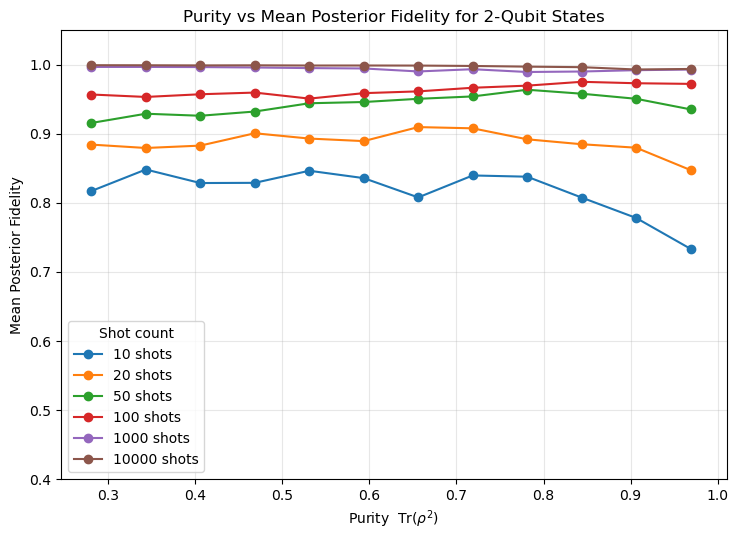

In [79]:
plot_purity_vs_posterior_fidelity_binned(res, title="Purity vs Mean Posterior Fidelity for 2-Qubit States")

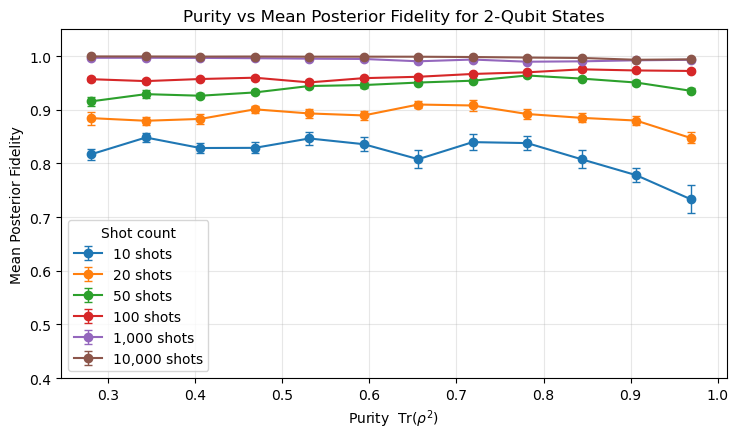

In [84]:
def plot_purity_vs_posterior_fidelity_binned(
    result_by_shots: Dict[int, dict],
    title="Purity vs Mean Posterior Fidelity (Bayesian QST)"
):
    plt.figure(figsize=(7.5, 4.5))

    for shots, res in sorted(result_by_shots.items(), key=lambda kv: kv[0]):
        x = res["bin_centers"]
        y = res["mean_fidelity_per_bin"]
        yerr = res["stderr_per_bin"]

        # mask bins where mean is NaN
        m = ~np.isnan(y)
        if not np.any(m):
            continue

        # Matplotlib ignores NaNs inside yerr automatically
        plt.errorbar(
            x[m], y[m], yerr=yerr[m],
            fmt='-o', capsize=3, elinewidth=1, linewidth=1.5,
            label=f"{shots:,} shots"
        )

    plt.xlabel("Purity  Tr($\\rho^2$)")
    plt.ylabel("Mean Posterior Fidelity")
    plt.ylim(0.4, 1.05)
    plt.xlim(None, 1.01)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Shot count")
    plt.title(title)
    plt.tight_layout()
    plt.show()
plot_purity_vs_posterior_fidelity_binned(res, title="Purity vs Mean Posterior Fidelity for 2-Qubit States")

/Users/stevenglass/Desktop/Project Final/Honours-Project/src/qst/models/bayes.py:193: RuntimeWarning: overflow encountered in exp
  r = np.exp(prop_post - curr_post)


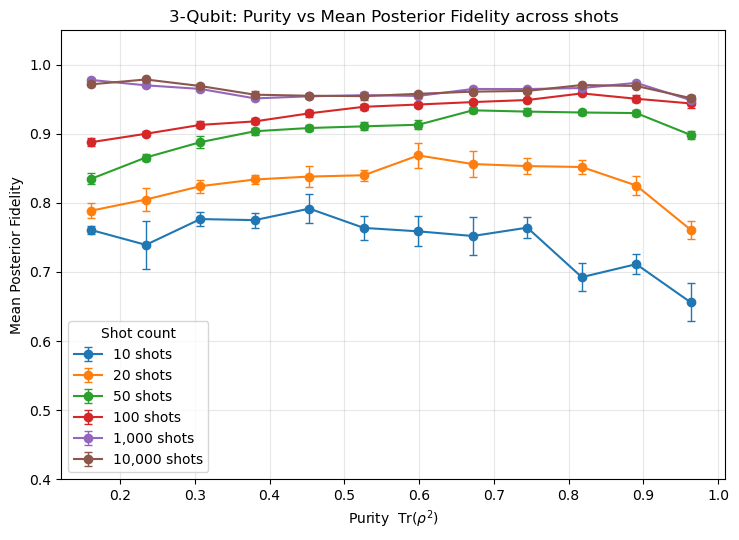

In [ ]:
bayes_3q = BayesQST(n_qubits=3)
datasets = {
    10: (X_3p_10, y_3p_10),
    20: (X_3p_20, y_3p_20),
    50: (X_3p_50, y_3p_50),
    100: (X_3p_100, y_3p_100),
    1000: (X_3p_1000, y_3p_1000),
    10000: (X_3p_10_000, y_3p_10_000),
}

res_3q = purity_vs_posterior_fidelity_by_shots(
    datasets,
    bayes_3q,
    n_states_per_shot=120,
    n_mcmc_samples=1000,
    burn_in=600,
    proposal_std=0.01,
    rng_seed=123,
    n_purity_bins=12,
    metric="bme_fidelity"
)



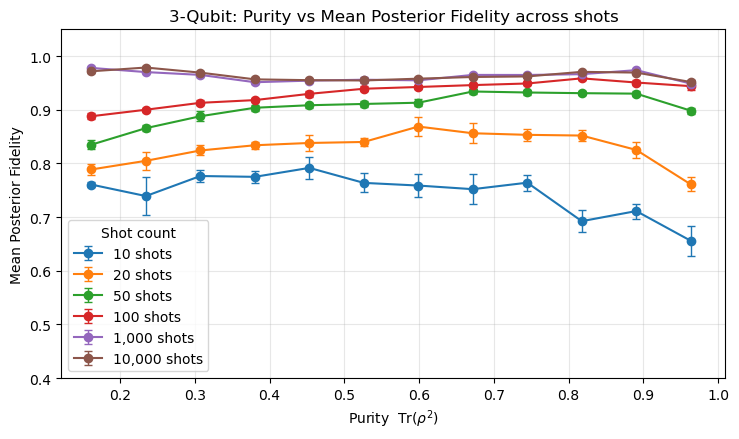

In [85]:
plot_purity_vs_posterior_fidelity_binned(res_3q, title="3-Qubit: Purity vs Mean Posterior Fidelity across shots")

In [ ]:

def plot_eigenvalue_histograms_by_purity(
    datasets: Dict[int, Tuple[np.ndarray, np.ndarray]],
    bayes: "BayesQST",
    shots: Optional[int] = None,
    purity_bins: list[tuple[float, float]] = None,
    n_states_per_bin: int = 60,
    posterior: str = "bme",
    n_mcmc_samples: int = 600,
    burn_in: int = 300,
    proposal_std: float = 0.01,
    rng_seed: int = 0,
    n_bins_hist: int = 25,
    sharey: bool = True,
    title: Optional[str] = None,
):

    rng = np.random.default_rng(rng_seed)
    d = 2 ** bayes.n_qubits
    pmin, pmax = 1.0 / d, 1.0

    # pick shot bucket (default: largest)
    if shots is None:
        shots = max(datasets.keys())
    X_counts, Y_true = datasets[shots]

    # default purity bands if not supplied
    if purity_bins is None:
        purity_bins = [(pmin, 0.5), (0.5, 0.8), (0.8, 1.0)]

    # compute true purities
    def _purity(rho): return float(np.real(np.trace(rho @ rho)))
    purities = np.array([_purity(rho) for rho in Y_true])

    # prepare collectors
    band_labels = [f"[{low:.3f}, {high:.3f})" if j < len(purity_bins)-1 else f"[{low:.3f}, {high:.3f}]"
                   for j, (low, high) in enumerate(purity_bins)]
    eigvals_by_band = [[] for _ in purity_bins]

    # helper: ensure PSD-ish numerics and unit trace
    def _eigvals_psd(rho: np.ndarray) -> np.ndarray:
        # Hermitian eigvals
        w = np.linalg.eigvalsh((rho + rho.T.conj()) * 0.5)
        # clip tiny negatives, renormalize trace to 1
        w = np.clip(np.real(w), 0.0, None)
        s = w.sum()
        if s > 0:
            w = w / s
        else:
            # fallback: uniform
            w = np.ones_like(w) / w.size
        return w

    # loop each band, sample states, run MCMC, collect eigenvalues
    for band_idx, (low, high) in enumerate(purity_bins):
        # mask for states in this purity band
        if band_idx < len(purity_bins) - 1:
            mask = (purities >= low) & (purities < high)
        else:
            mask = (purities >= low) & (purities <= high)

        idxs = np.flatnonzero(mask)
        if idxs.size == 0:
            continue
        take = min(n_states_per_bin, idxs.size)
        pick = rng.choice(idxs, size=take, replace=False)

        for i in _tqdm(pick, desc=f"Shots={shots} | Purity band {band_labels[band_idx]}"):
            counts_i = X_counts[i]
            # run MCMC
            samples, _acc = bayes.metropolis_sampler(
                counts=counts_i,
                n_samples=n_mcmc_samples,
                proposal_std=proposal_std,
                burn_in=burn_in,
                random_state=int(rng.integers(0, 2**31 - 1)),
            )

            if posterior == "bme":
                rhos = [bayes.params_to_rho(samples[t]) for t in range(n_mcmc_samples)]
                rho_bme = np.mean(rhos, axis=0)
                w = _eigvals_psd(rho_bme)
                eigvals_by_band[band_idx].extend(w.tolist())
            else:
                # aggregate eigenvalues from *all* posterior samples
                for t in range(n_mcmc_samples):
                    rho_t = bayes.params_to_rho(samples[t])
                    w = _eigvals_psd(rho_t)
                    eigvals_by_band[band_idx].extend(w.tolist())

    # plotting
    n_bands = len(purity_bins)
    fig, axes = plt.subplots(1, n_bands, figsize=(4.5 * n_bands, 3.8), sharey=sharey)
    if n_bands == 1:
        axes = [axes]

    for ax, label, vals in zip(axes, band_labels, eigvals_by_band):
        vals = np.array(vals, dtype=float)
        if vals.size == 0:
            ax.set_visible(False)
            continue
        ax.hist(vals, bins=n_bins_hist, alpha=0.85, density=True)
        ax.set_xlabel("Eigenvalue")
        ax.set_title(f"Purity {label}\n(n eigvals={vals.size})")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Density")
    if title is None:
        title = (f"Bayesian eigenvalue histograms by purity bands "
                 f"({posterior.upper()}, shots={shots})")
    fig.suptitle(title)
    plt.ylim(0, 25)

    fig.tight_layout()
    plt.show()


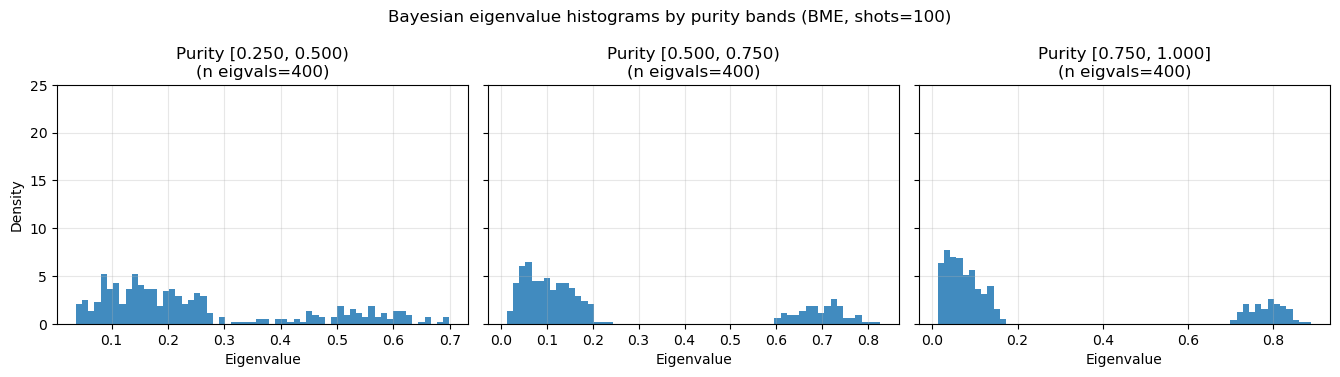

In [88]:
datasets_2q = {
    100: (X_2p_100, y_2p_100)

}

bayes_2q = BayesQST(n_qubits=2)

plot_eigenvalue_histograms_by_purity(
    datasets_2q, bayes_2q,
    posterior="bme",
    n_states_per_bin=100,
    n_mcmc_samples=500,
    burn_in=100,
    purity_bins=[(1/4, 0.5), (0.5, 0.75), (0.75, 1.0)],
    n_bins_hist=60
)



In [56]:
def collect_eigvals_by_shots_and_purity(
    datasets: Dict[int, Tuple[np.ndarray, np.ndarray]],
    bayes: "BayesQST",
    shots_list: Optional[list[int]] = None,
    purity_bins: Optional[list[tuple[float, float]]] = None,
    n_states_per_bin: int = 60,
    posterior: str = "bme",        # "bme" or "samples"
    n_mcmc_samples: int = 600,
    burn_in: int = 300,
    proposal_std: float = 0.01,
    rng_seed: int = 0,
) -> tuple[dict, list[str], list[int]]:
    """Return {(shots, band_idx): np.ndarray of eigenvalues}, band_labels, ordered_shots."""
    rng = np.random.default_rng(rng_seed)
    d = 2 ** bayes.n_qubits
    pmin, pmax = 1.0 / d, 1.0

    if shots_list is None:
        shots_list = sorted(datasets.keys())

    if purity_bins is None:
        purity_bins = [(pmin, 0.5), (0.5, 0.8), (0.8, 1.0)]

    band_labels = [f"[{lo:.3f}, {hi:.3f})" if j < len(purity_bins)-1 else f"[{lo:.3f}, {hi:.3f}]"
                   for j, (lo, hi) in enumerate(purity_bins)]

    def _purity(rho): return float(np.real(np.trace(rho @ rho)))

    def _eigvals_psd(rho: np.ndarray) -> np.ndarray:
        w = np.linalg.eigvalsh((rho + rho.T.conj()) * 0.5)
        w = np.clip(np.real(w), 0.0, None)
        s = w.sum()
        return (w / s) if s > 0 else np.ones_like(w) / w.size

    out: dict[tuple[int, int], list[float]] = {}

    for shots in shots_list:
        X_counts, Y_true = datasets[shots]
        purities = np.array([_purity(rho) for rho in Y_true])

        for band_idx, (low, high) in enumerate(purity_bins):
            if band_idx < len(purity_bins) - 1:
                mask = (purities >= low) & (purities < high)
            else:
                mask = (purities >= low) & (purities <= high)

            idxs = np.flatnonzero(mask)
            if idxs.size == 0:
                out[(shots, band_idx)] = []
                continue

            take = min(n_states_per_bin, idxs.size)
            pick = rng.choice(idxs, size=take, replace=False)

            eigvals = []
            for i in pick:
                samples, _acc = bayes.metropolis_sampler(
                    counts=X_counts[i],
                    n_samples=n_mcmc_samples,
                    proposal_std=proposal_std,
                    burn_in=burn_in,
                    random_state=int(rng.integers(0, 2**31 - 1)),
                )

                if posterior == "bme":
                    rhos = [bayes.params_to_rho(samples[t]) for t in range(n_mcmc_samples)]
                    rho_bme = np.mean(rhos, axis=0)
                    eigvals.extend(_eigvals_psd(rho_bme).tolist())
                else:
                    for t in range(n_mcmc_samples):
                        eigvals.extend(_eigvals_psd(bayes.params_to_rho(samples[t])).tolist())

            out[(shots, band_idx)] = eigvals

    return out, band_labels, shots_list


def plot_eigenvalue_grid(
    datasets: Dict[int, Tuple[np.ndarray, np.ndarray]],
    bayes: "BayesQST",
    shots_list: Optional[list[int]] = None,
    purity_bins: Optional[list[tuple[float, float]]] = None,
    n_states_per_bin: int = 60,
    posterior: str = "bme",
    n_mcmc_samples: int = 600,
    burn_in: int = 300,
    proposal_std: float = 0.01,
    rng_seed: int = 0,
    n_bins_hist: int = 25,
    kind: str = "hist",   # "hist" | "ecdf" | "violin"
    sharex: bool = True,
    sharey: bool = True,
    title: Optional[str] = None,
):
    eigmap, band_labels, shots_list = collect_eigvals_by_shots_and_purity(
        datasets, bayes, shots_list, purity_bins, n_states_per_bin,
        posterior, n_mcmc_samples, burn_in, proposal_std, rng_seed
    )

    n_rows, n_cols = len(shots_list), len(band_labels)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.2*n_cols, 3.6*n_rows),
                             sharex=sharex, sharey=sharey)
    if n_rows == 1:
        axes = np.array([axes])
    if n_cols == 1:
        axes = axes.reshape(n_rows, 1)

    for r, shots in enumerate(shots_list):
        for c, label in enumerate(band_labels):
            ax = axes[r, c]
            vals = np.asarray(eigmap.get((shots, c), []), dtype=float)
            if vals.size == 0:
                ax.set_visible(False)
                continue

            if kind == "hist":
                ax.hist(vals, bins=n_bins_hist, density=True, alpha=0.9)
                ax.set_ylabel("Density" if (c == 0) else "")
            elif kind == "ecdf":
                # simple ECDF
                x = np.sort(vals)
                y = np.arange(1, x.size+1) / x.size
                ax.step(x, y, where="post")
                ax.set_ylabel("ECDF" if (c == 0) else "")
                ax.set_ylim(0, 1.02)
            elif kind == "violin":
                ax.violinplot(vals, showextrema=False, showmeans=True)
                ax.set_ylabel("Density" if (c == 0) else "")
                ax.set_xlim(0.0, 1.0)

            if r == 0:
                ax.set_title(f"Purity {label}")
            if c == 0:
                ax.set_xlabel("")
                ax.text(0.02, 0.95, f"shots={shots}\n(n={vals.size})",
                        transform=ax.transAxes, va="top", ha="left",
                        bbox=dict(boxstyle="round", fc="w", alpha=0.6, lw=0.0))
            ax.set_xlabel("Eigenvalue")
            ax.grid(True, alpha=0.3)

    if title is None:
        title = f"Eigenvalue distributions by shots × purity bands ({posterior.upper()})"
    fig.suptitle(title, y=0.995)
    fig.tight_layout()
    plt.show()


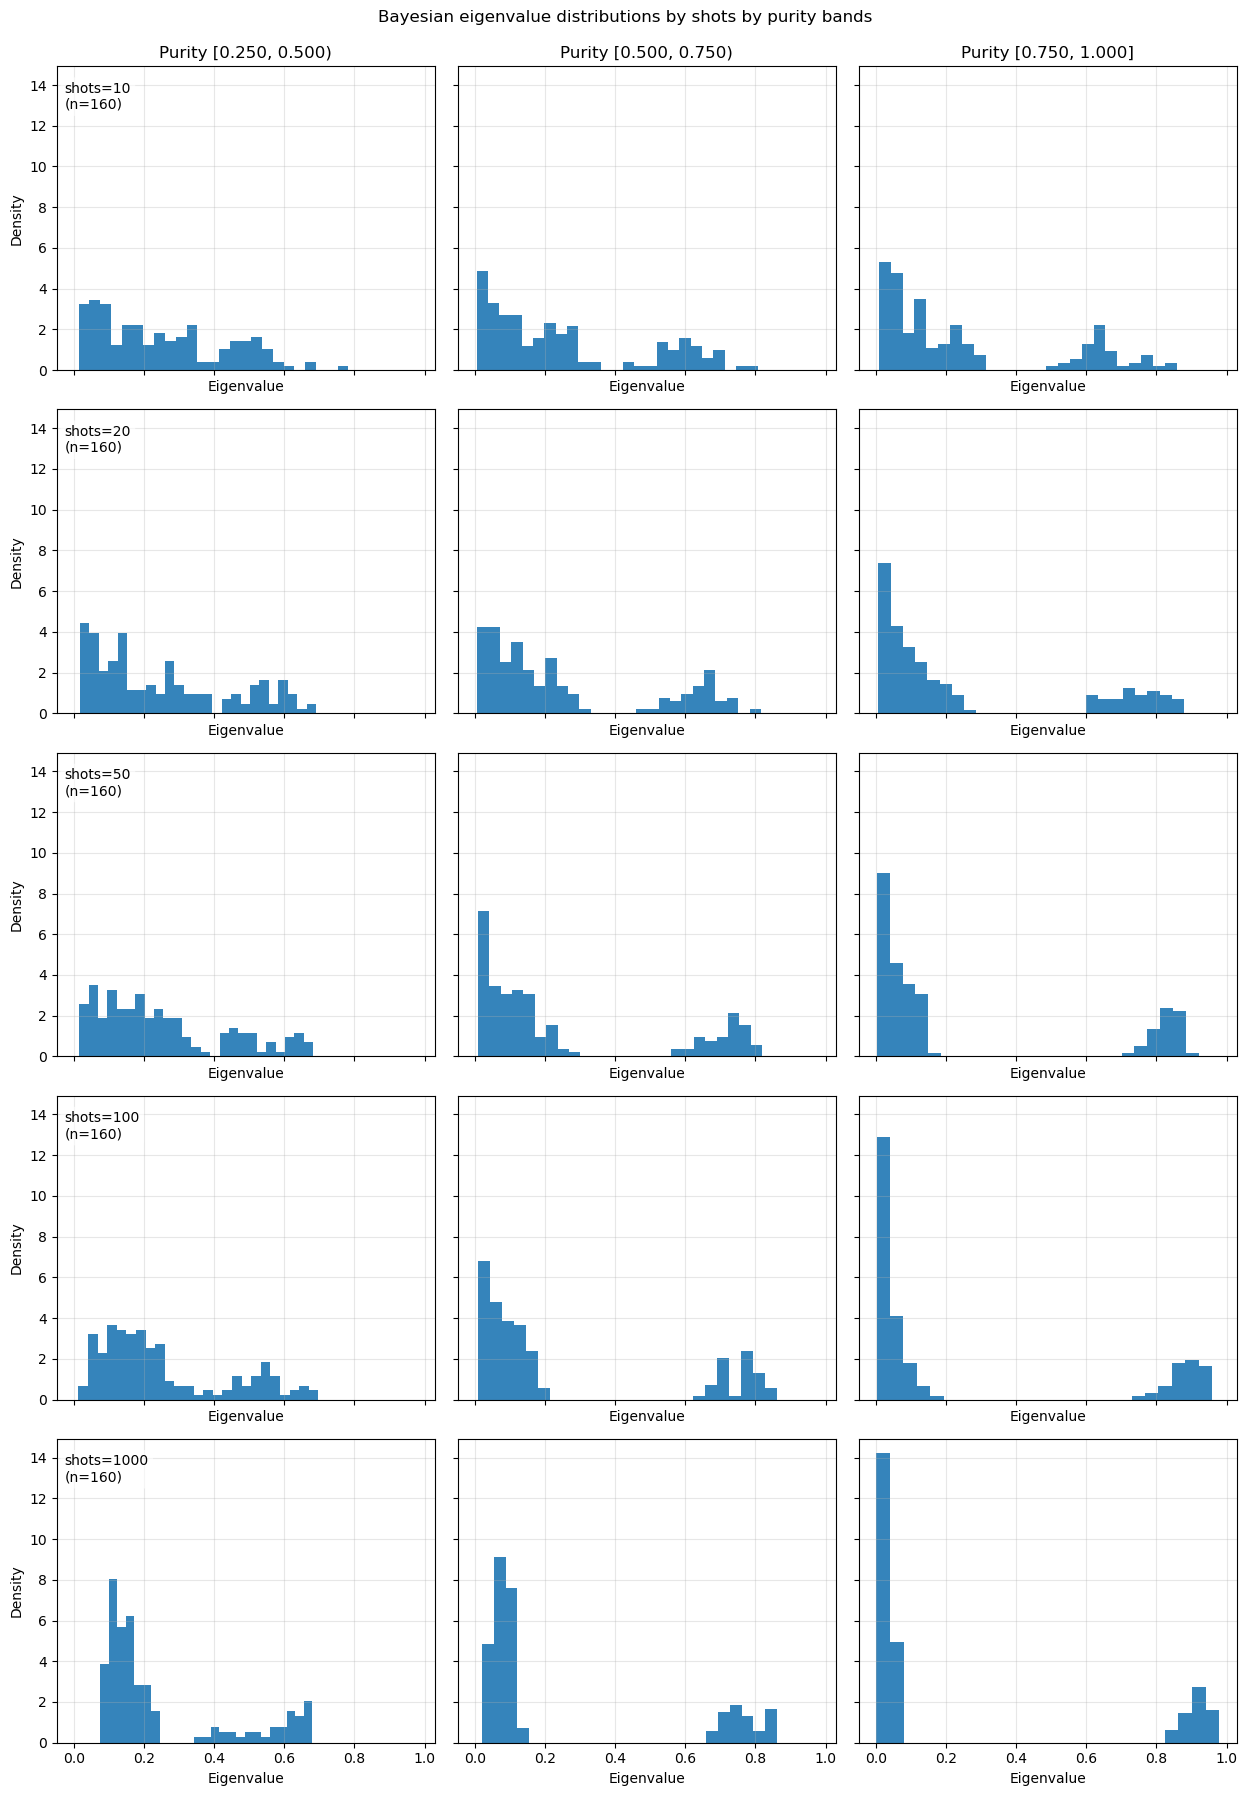

In [60]:
datasets_2q = {
    10: (X_2p_10, y_2p_10),
    20: (X_2p_20, y_2p_20),
    50: (X_2p_50, y_2p_50),
    100: (X_2p_100, y_2p_100),
    1000: (X_2p_1000, y_2p_1000)

}

bayes_2q = BayesQST(n_qubits=2)

plot_eigenvalue_grid(
    datasets=datasets_2q,
    bayes=bayes_2q,
    purity_bins=[(0.25, 0.5), (0.5, 0.75), (0.75, 1.0)],
    n_states_per_bin=40,
    posterior="bme",
    n_mcmc_samples=600,
    burn_in=300,
    kind="hist",                # "hist", "ecdf", or "violin"
    title="Bayesian eigenvalue distributions by shots by purity bands"
)


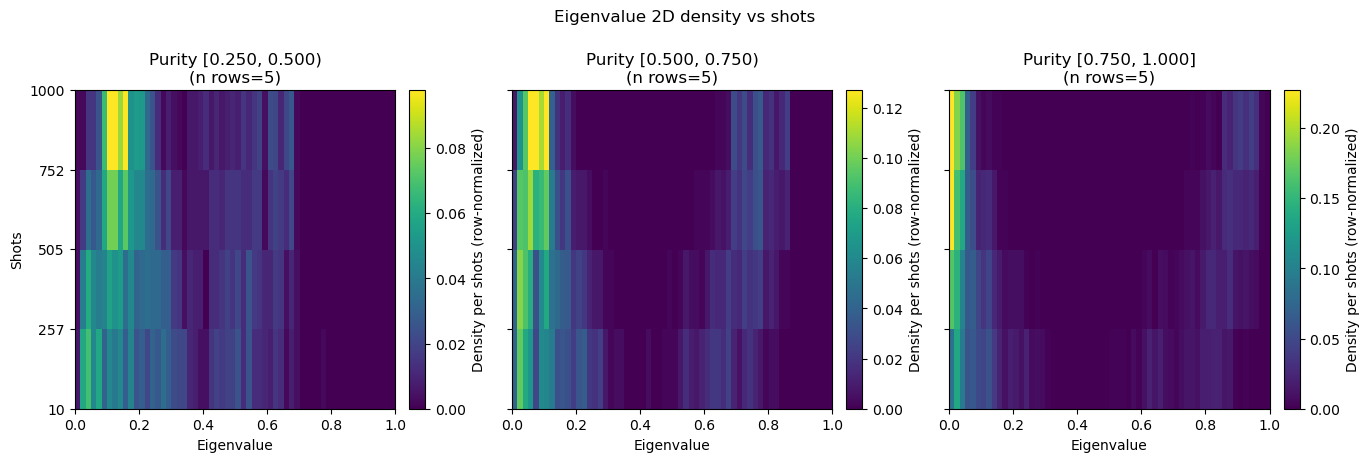

In [ ]:

def _eigvals_psd(rho: np.ndarray) -> np.ndarray:
    # Hermitianize, clip tiny negatives, renormalize to unit trace
    w = np.linalg.eigvalsh((rho + rho.T.conj()) * 0.5)
    w = np.clip(np.real(w), 0.0, None)
    s = w.sum()
    return (w / s) if s > 0 else np.ones_like(w) / w.size

def _purity(rho: np.ndarray) -> float:
    return float(np.real(np.trace(rho @ rho)))

def _moving_average_2d(Z: np.ndarray, k_rows: int = 1, k_cols: int = 1) -> np.ndarray:
    """Very light separable box smoothing without external deps."""
    if k_rows <= 1 and k_cols <= 1:
        return Z
    out = Z.copy()
    if k_rows > 1:
        pad = k_rows // 2
        tmp = np.pad(out, ((pad, pad), (0, 0)), mode="edge")
        csum = np.cumsum(tmp, axis=0)
        out = (csum[k_rows:] - csum[:-k_rows]) / k_rows
    if k_cols > 1:
        pad = k_cols // 2
        tmp = np.pad(out, ((0, 0), (pad, pad)), mode="edge")
        csum = np.cumsum(tmp, axis=1)
        out = (csum[:, k_cols:] - csum[:, :-k_cols]) / k_cols
    return out

# ---------- data collection ----------
def collect_eigvals_by_shots_and_purity(
    datasets: Dict[int, Tuple[np.ndarray, np.ndarray]],
    bayes: "BayesQST",
    shots_list: Optional[List[int]] = None,
    purity_bins: Optional[List[tuple[float, float]]] = None,
    n_states_per_bin: int = 60,
    posterior: str = "bme",          # "bme" or "samples"
    n_mcmc_samples: int = 600,
    burn_in: int = 300,
    proposal_std: float = 0.01,
    rng_seed: int = 0,
) -> tuple[dict, List[str], List[int]]:
    """Return {(shots, band_idx): list[eigenvalues]} plus labels and ordered shots."""
    rng = np.random.default_rng(rng_seed)
    d = 2 ** bayes.n_qubits
    pmin = 1.0 / d

    if shots_list is None:
        shots_list = sorted(datasets.keys())
    if purity_bins is None:
        purity_bins = [(pmin, 0.5), (0.5, 0.8), (0.8, 1.0)]

    band_labels = [f"[{lo:.3f}, {hi:.3f})" if j < len(purity_bins)-1 else f"[{lo:.3f}, {hi:.3f}]"
                   for j, (lo, hi) in enumerate(purity_bins)]

    out: dict[tuple[int, int], List[float]] = {}
    for shots in shots_list:
        X_counts, Y_true = datasets[shots]
        purities = np.array([_purity(rho) for rho in Y_true])

        for b, (low, high) in enumerate(purity_bins):
            mask = (purities >= low) & (purities < high if b < len(purity_bins)-1 else purities <= high)
            idxs = np.flatnonzero(mask)
            if idxs.size == 0:
                out[(shots, b)] = []
                continue

            take = min(n_states_per_bin, idxs.size)
            pick = rng.choice(idxs, size=take, replace=False)

            vals: List[float] = []
            for i in pick:
                samples, _ = bayes.metropolis_sampler(
                    counts=X_counts[i],
                    n_samples=n_mcmc_samples,
                    proposal_std=proposal_std,
                    burn_in=burn_in,
                    random_state=int(rng.integers(0, 2**31 - 1)),
                )

                if posterior == "bme":
                    rhos = [bayes.params_to_rho(samples[t]) for t in range(n_mcmc_samples)]
                    rho_bme = np.mean(rhos, axis=0)
                    vals.extend(_eigvals_psd(rho_bme).tolist())
                else:
                    for t in range(n_mcmc_samples):
                        vals.extend(_eigvals_psd(bayes.params_to_rho(samples[t])).tolist())

            out[(shots, b)] = vals
    return out, band_labels, shots_list

# ---------- plotting ----------
def plot_eig_density_heatmaps(
    datasets: Dict[int, Tuple[np.ndarray, np.ndarray]],
    bayes: "BayesQST",
    shots_list: Optional[List[int]] = None,
    purity_bins: Optional[List[tuple[float, float]]] = None,
    n_states_per_bin: int = 60,
    posterior: str = "bme",
    n_mcmc_samples: int = 600,
    burn_in: int = 300,
    proposal_std: float = 0.01,
    rng_seed: int = 0,
    nbins_x: int = 60,
    smooth_rows: int = 1,   # try 3 for mild smoothing across shots
    smooth_cols: int = 1,   # try 3 for mild smoothing across eigenvalue bins
    cmap: str = "viridis",
    title: Optional[str] = None,
):
    """
    2D density heatmaps (one per purity band).
    Rows correspond to shot counts; columns to eigenvalue bins.
    Each row is normalized to sum to 1 (density per-shots).
    """
    data, band_labels, shots_list = collect_eigvals_by_shots_and_purity(
        datasets, bayes, shots_list, purity_bins, n_states_per_bin,
        posterior, n_mcmc_samples, burn_in, proposal_std, rng_seed
    )

    x_min, x_max = 0.0, 1.0
    edges_x = np.linspace(x_min, x_max, nbins_x + 1)
    centers_x = 0.5 * (edges_x[:-1] + edges_x[1:])
    n_rows = len(shots_list)

    fig, axes = plt.subplots(1, len(band_labels),
                             figsize=(4.6*len(band_labels), 4.6),
                             sharey=True)

    if len(band_labels) == 1:
        axes = [axes]

    for ax, (b, label) in zip(axes, enumerate(band_labels)):
        # Build matrix Z: rows=shots (ascending), cols=eig bins
        Z = np.zeros((n_rows, nbins_x), dtype=float)
        for r, shots in enumerate(shots_list):
            vals = np.asarray(data.get((shots, b), []), dtype=float)
            if vals.size > 0:
                hist, _ = np.histogram(vals, bins=edges_x, density=False)
                # Normalize row to density (sum=1). Add tiny eps to avoid div by zero.
                s = hist.sum()
                Z[r, :] = hist / (s if s > 0 else 1.0)

        # Optional smoothing (pure numpy box filter)
        Zs = _moving_average_2d(Z, k_rows=smooth_rows, k_cols=smooth_cols)

        # Show with imshow
        im = ax.imshow(
            Zs,
            origin="lower",
            aspect="auto",
            extent=[x_min, x_max, min(shots_list), max(shots_list)],
            cmap=cmap,
            interpolation="nearest",
            vmin=0.0, vmax=np.percentile(Zs, 99.5) if Zs.max() > 0 else 1.0
        )
        ax.set_xlabel("Eigenvalue")
        ax.set_title(f"Purity {label}\n(n rows={n_rows})")
        ax.grid(False)

        # Nice ticks for shots
        yticks = np.linspace(min(shots_list), max(shots_list), num=min(n_rows, 6), dtype=int)
        ax.set_yticks(yticks)

        # Colorbar per panel (keeps each panel self-contained)
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Density per shots (row-normalized)")

    axes[0].set_ylabel("Shots")
    if title is None:
        title = f"Eigenvalue density vs shots by purity bands ({posterior.upper()})"
    fig.suptitle(title, y=0.995)
    fig.tight_layout()
    plt.show()



datasets_2q = {
    10: (X_2p_10, y_2p_10),
    20: (X_2p_20, y_2p_20),
    50: (X_2p_50, y_2p_50),
    100: (X_2p_100, y_2p_100),
    1000: (X_2p_1000, y_2p_1000)

}

bayes_2q = BayesQST(n_qubits=2)


plot_eig_density_heatmaps(
    datasets=datasets_2q,
    bayes=bayes_2q,
    shots_list=sorted(datasets_2q.keys()),
    purity_bins=[(0.25, 0.5), (0.5, 0.75), (0.75, 1.0)],
    n_states_per_bin=40,
    posterior="bme", 
    nbins_x=60,
    smooth_rows=3,
    smooth_cols=1,
    cmap="viridis",
    title="Eigenvalue 2D density vs shots"
)


In [ ]:

Array = np.ndarray
Datasets = Dict[int, Tuple[Array, Array]]



def bme_from_counts(
    bayes,
    counts: Array,
    n_samples: int,
    burn_in: int,
    proposal_std: float = 0.01,
    random_state: Optional[int] = None,
) -> Tuple[np.ndarray, Dict[str, Any]]:

    t0 = time.perf_counter()
    theta_samples, acc = bayes.metropolis_sampler(
        counts=counts,
        n_samples=n_samples,
        proposal_std=proposal_std,
        burn_in=burn_in,
        random_state=random_state,
    )

    rhos = np.stack([bayes.params_to_rho(theta) for theta in theta_samples], axis=0)
    rho_bme = rhos.mean(axis=0)
    elapsed = time.perf_counter() - t0

    return rho_bme, {"accept_ratio": float(acc), "time_seconds": float(elapsed)}

def find_bme_samples_for_target_fidelity_on_dataset(
    bayes,
    X: Array,                     # counts per state
    Y: Array,                     # ground-truth density matrices per state
    sample_counts: List[int] = (200, 400, 800, 1600, 3200, 6400),
    target_fidelity: float = 0.95,
    burn_in_fraction: float = 0.5,
    n_states_to_eval: int = 30,
    proposal_std: float = 0.01,
    rng_seed: int = 0,
) -> Dict[str, Any]:
    
    rng = np.random.default_rng(rng_seed)
    N = len(X)
    idx = rng.choice(N, size=min(n_states_to_eval, N), replace=False)

    per_n = []
    first_hit = None

    for n_samp in sample_counts:
        burn_in = max(0, int(burn_in_fraction * n_samp))
        if burn_in >= n_samp:
            burn_in = max(0, n_samp - 1)

        t0 = time.perf_counter()
        Fs = []
        time_accum = 0.0
        accs = []

        # Reconstruct each selected state with *BME* at current chain length
        for i in idx:
            rho_bme, info = bme_from_counts(
                bayes,
                counts=X[i],
                n_samples=n_samp,
                burn_in=burn_in,
                proposal_std=proposal_std,
                random_state=int(rng.integers(0, 2**31 - 1)),
            )
            F = fidelity(rho_bme, Y[i])
            Fs.append(F)
            time_accum += info["time_seconds"]
            accs.append(info["accept_ratio"])

        elapsed = time.perf_counter() - t0
        Fs = np.asarray(Fs, dtype=float)
        meanF = float(Fs.mean())
        stdF = float(Fs.std(ddof=1) if len(Fs) > 1 else 0.0)
        mean_acc = float(np.mean(accs)) if accs else np.nan

        row = {
            "n_mcmc_samples": n_samp,
            "burn_in": burn_in,
            "meanF": meanF,
            "stdF": stdF,
            "n_states": int(len(Fs)),
            "time_seconds_total_wall": elapsed,            # wall-clock for the sweep at this n
            "time_seconds_sum_of_calls": time_accum,       # sum of per-call timings
            "time_seconds_per_state": time_accum / len(Fs) if len(Fs) else np.nan,
            "mean_accept_ratio": mean_acc,
        }
        per_n.append(row)

        if meanF >= target_fidelity and first_hit is None:
            first_hit = row

    return {"target": target_fidelity, "per_n": per_n, "first_hit": first_hit}


def find_bme_samples_for_target_fidelity_across_shots(
    bayes,
    datasets: Dict[int, Tuple[Array, Array]],  # {shots: (X, Y)}
    sample_counts: List[int] = (200, 400, 800, 1600, 3200, 6400, 12800),
    target_fidelity: float = 0.95,
    burn_in_fraction: float = 0.5,
    n_states_to_eval: int = 30,
    proposal_std: float = 0.01,
    rng_seed: int = 0,
) -> Dict[int, Dict[str, Any]]:
    results = {}
    for shots in sorted(datasets.keys()):
        X, Y = datasets[shots]
        res = find_bme_samples_for_target_fidelity_on_dataset(
            bayes=bayes,
            X=X, Y=Y,
            sample_counts=sample_counts,
            target_fidelity=target_fidelity,
            burn_in_fraction=burn_in_fraction,
            n_states_to_eval=n_states_to_eval,
            proposal_std=proposal_std,
            rng_seed=rng_seed,
        )
        results[shots] = res
    return results

datasets_2q = {
    10: (X_2p_10, y_2p_10),
    20: (X_2p_20, y_2p_20),
    50: (X_2p_50, y_2p_50),
    100: (X_2p_100, y_2p_100),
    1000: (X_2p_1000, y_2p_1000),
    10000: (X_2p_10_000, y_2p_10_000)
}

bayes_2q = BayesQST(n_qubits=2)
results = find_bme_samples_for_target_fidelity_across_shots(
    bayes=bayes_2q,
    datasets=datasets_2q, 
    sample_counts=[200, 400, 800, 1600, 3200, 6400],
    target_fidelity=0.99,
    burn_in_fraction=0.5,
    n_states_to_eval=30,
    proposal_std=0.01,
    rng_seed=123,
)

for shots, res in sorted(results.items()):
    hit = res["first_hit"]
    if hit is None:
        print(f"[shots={shots}] never reached {res['target']:.2f} up to max n_mcmc_samples.")
    else:
        print(
            f"[shots={shots}] target {res['target']:.2f} first hit at n={hit['n_mcmc_samples']}, "
            f"meanF={hit['meanF']:.4f}±{hit['stdF']:.4f}, "
            f"time≈{hit['time_seconds_per_state']:.3f}s/state "
            f"(burn-in={hit['burn_in']}, acc≈{hit['mean_accept_ratio']:.2f})"
        )




[shots=10] never reached 0.99 up to max n_mcmc_samples.
[shots=20] never reached 0.99 up to max n_mcmc_samples.
[shots=50] never reached 0.99 up to max n_mcmc_samples.
[shots=100] never reached 0.99 up to max n_mcmc_samples.
[shots=1000] target 0.99 first hit at n=400, meanF=0.9915±0.0073, time≈0.022s/state (burn-in=200, acc≈0.31)
[shots=10000] target 0.99 first hit at n=400, meanF=0.9932±0.0082, time≈0.022s/state (burn-in=200, acc≈0.18)


In [ ]:
bayes_3q = BayesQST(n_qubits=3)

datasets_3q = {
    10: (X_3p_10, y_3p_10),
    20: (X_3p_20, y_3p_20),
    50: (X_3p_50, y_3p_50),
    100: (X_3p_100, y_3p_100),
    1000: (X_3p_1000, y_3p_1000),
    10000: (X_3p_10_000, y_3p_10_000),
    100000: (X_3p_10_000, y_3p_10_000),  # duplicate to test higher shots
}

results = find_bme_samples_for_target_fidelity_across_shots(
    bayes=bayes_3q,
    datasets=datasets_3q, 
    sample_counts=[200, 400, 800, 1600, 3200, 6400],
    target_fidelity=0.99,
    burn_in_fraction=0.5,
    n_states_to_eval=30,
    proposal_std=0.01,
    rng_seed=123,
)

for shots, res in sorted(results.items()):
    hit = res["first_hit"]
    if hit is None:
        print(f"[shots={shots}] never reached {res['target']:.2f} up to max n_mcmc_samples.")
    else:
        print(
            f"[shots={shots}] target {res['target']:.2f} first hit at n={hit['n_mcmc_samples']}, "
            f"meanF={hit['meanF']:.4f}±{hit['stdF']:.4f}, "
            f"time≈{hit['time_seconds_per_state']:.3f}s/state "
            f"(burn-in={hit['burn_in']}, acc≈{hit['mean_accept_ratio']:.2f})"
        )

/Users/stevenglass/Desktop/Project Final/Honours-Project/src/qst/models/bayes.py:193: RuntimeWarning: overflow encountered in exp
  r = np.exp(prop_post - curr_post)


[shots=10] never reached 0.99 up to max n_mcmc_samples.
[shots=20] never reached 0.99 up to max n_mcmc_samples.
[shots=50] never reached 0.99 up to max n_mcmc_samples.
[shots=100] never reached 0.99 up to max n_mcmc_samples.
[shots=1000] never reached 0.99 up to max n_mcmc_samples.
[shots=10000] never reached 0.99 up to max n_mcmc_samples.


In [53]:
datasets_3q = {

    100000: (X_3p_10_000, y_3p_10_000)
}

results = find_bme_samples_for_target_fidelity_across_shots(
    bayes=bayes_3q,
    datasets=datasets_3q, 
    sample_counts=[200, 400, 800, 1600, 3200, 6400, 12800, 25600],
    target_fidelity=0.98,
    burn_in_fraction=0.5,
    n_states_to_eval=30,
    proposal_std=0.01,
    rng_seed=123,
)

for shots, res in sorted(results.items()):
    hit = res["first_hit"]
    if hit is None:
        print(f"[shots={shots}] never reached {res['target']:.2f} up to max n_mcmc_samples.")
    else:
        print(
            f"[shots={shots}] target {res['target']:.2f} first hit at n={hit['n_mcmc_samples']}, "
            f"meanF={hit['meanF']:.4f}±{hit['stdF']:.4f}, "
            f"time≈{hit['time_seconds_per_state']:.3f}s/state "
            f"(burn-in={hit['burn_in']}, acc≈{hit['mean_accept_ratio']:.2f})"
        )

[shots=100000] target 0.98 first hit at n=25600, meanF=0.9801±0.0147, time≈3.391s/state (burn-in=12800, acc≈0.01)
